In [1]:
import torch

from app.vision.dense_cap import detection_utils as utils
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [2]:
dm = DataManager()
dm.load_test()

In [3]:
aug = MNISTAug()
x, y = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [4]:
x = torch.tensor(x,  dtype=torch.float32).view((-1, 1, 112, 112))

In [5]:
y[0][0]

{'id': 0,
 'class': 6,
 'class_one_hot': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'x1': 27,
 'y1': 33,
 'x2': 91,
 'y2': 97,
 'cx': 59.0,
 'cy': 65.0,
 'height': 64,
 'width': 64,
 'type': 'number'}

/home/ak/Repos/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:444: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


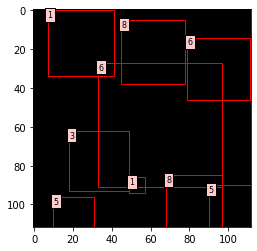

In [6]:

H = 14
W = 14
H_full = 112
W_full = 112
k = 9

i = 0

y_ = utils.labels_to_tensor(y[i], 112, 112)

anchors_tensor = utils.generate_anchors(shape=(W, H), sizes=(.15, .45, .75), ratios=(0.5, 1, 2))

DataManager.plot_num(torch.ones((112, 112)), y[0])

iou = utils.get_iou_map(y_, anchors_tensor)

In [7]:
confidences, diffs = utils.get_labels(iou, y_, anchors_tensor, k, H, W, confidence_threshold=0.6)

In [ ]:
def sample_pn_indices(confidences: torch.Tensor, threshold_p:float, threshold_n: float, b_samples:int):
    """
    Parameters
    ----------
    confidences: A flat 1D tensor of confidences
    threshold_p: something like 0.7
    threshold_n: something like 0.3
    b_samples: b number of samples. Something like 256 / 300

    Returns
    -------
    A tuple of two tensors. Each containing arbitrary number of indices.
    """

    positive_indices = torch.nonzero(confidences >= threshold_p).flatten(0)
    negative_indices = torch.nonzero(confidences <= threshold_n).flatten(0)

    bp = min(len(positive_indices), b / 2)
    sampled_indices = torch.multinomial(torch.ones(len(positive_indices)), bp)  # Sampled
    positive_indices = positive_indices[sampled_indices]

    bn = min(len(negative_indices), b - bp)
    sampled_indices = torch.multinomial(torch.ones(len(negative_indices)), bn)  # Sampled
    negative_indices = negative_indices[sampled_indices]

    return positive_indices, negative_indices

In [ ]:
def get_pred_bboxes(diffs:torch.Tensor, anchors:torch.Tensor, idx_p:torch.Tensor, idx_n: torch.Tensor):
    """
    Parameters
    ----------
    idx_p: 1D positive indices tensor
    idx_n: 1D -ve indices tensor
    diffs: Tensor of shape (4, k, H, W)
    anchors: Tensor of shape (4, k*H*W)

    Returns
    -------
    A tuple of two tensors -> (4, np), (4, nn)

    Steps
    -------
    1. Extract +ve and -ve anchors
    2. Flatten out diffs at dim 1 to make a diffs tensor of shape (4, k*H*W)
    3. Extract +ve and -ve diffs
    4. Apply diffs to anchors
    5. return pred bboxes
    """

    anchors_p = anchors[:, idx_p]
    anchors_n = anchors[:, idx_n]

    diffs = diffs.view((4, -1))
    diffs_p = diffs[:, idx_p]
    diffs_n = diffs[:, idx_n]

    bb_p = apply_diff(anchors_p, diffs_p)
    bb_n = apply_diff(anchors_n, diffs_n)

    return bb_p, bb_n

    positive_anchor_indices = torch.nonzero(confidences == 1).T  # Shape: 3, n  n = number of positives predicted
    len_positives = positive_anchor_indices.shape[1]

    cx_indices = positive_anchor_indices
    cy_indices = torch.stack((positive_anchor_indices[0] + torch.ones(len_positives) * k, positive_anchor_indices[1], positive_anchor_indices[2])).type(torch.long)
    w_indices = torch.stack((positive_anchor_indices[0] + torch.ones(len_positives) * 2 * k, positive_anchor_indices[1], positive_anchor_indices[2])).type(torch.long)
    h_indices = torch.stack((positive_anchor_indices[0] + torch.ones(len_positives) * 3 * k, positive_anchor_indices[1], positive_anchor_indices[2])).type(torch.long)

    cx_diffs = diffs[tuple(cx_indices)]
    cy_diffs = diffs[tuple(cy_indices)]
    w_diffs = diffs[tuple(w_indices)]
    h_diffs = diffs[tuple(h_indices)]

    pred_boxes = torch.empty((len_positives, 4), dtype=torch.float32)

    for i in range(len_positives):
        idx = cx_indices.T[i]
        anchor_idx = ravel_indices(idx, diffs.shape)

        b = apply_diff(anchors_tensor[:, anchor_idx], (cx_diffs[i], cy_diffs[i], w_diffs[i], h_diffs[i]))
        pred_boxes[i] = b

    pred_boxes = centers_to_diag(pred_boxes)

    # Now do the Non Maximal Suppression and filter out the duplicates







In [8]:
def nms():
    pass

tensor([[ 4, 11,  2],
        [ 4, 11, 11],
        [ 5,  6,  2],
        [ 5,  6, 11]])

In [ ]:
torch.nonzero(confidences > 0.3)

In [9]:
torch.nonzero(confidences <= 0.3).shape

torch.Size([1760, 3])

In [10]:
y_[i].shape

torch.Size([9])

In [11]:
positive_anchor_indices = torch.nonzero(confidences == 1).T

In [12]:
positive_anchor_indices

tensor([[ 4,  4,  5,  5],
        [11, 11,  6,  6],
        [ 2, 11,  2, 11]])

In [33]:
diffs[tuple(positive_anchor_indices)]

tensor([ 0.1389, -0.0198,  0.1389, -0.0198])

In [14]:
diffs.shape

torch.Size([36, 14, 14])

In [15]:
len_positives = positive_anchor_indices.shape[1]
len_positives

4

In [16]:
cx_indices = positive_anchor_indices
cy_indices = torch.stack((positive_anchor_indices[0] + torch.ones(len_positives) * k, positive_anchor_indices[1], positive_anchor_indices[2])).type(torch.long)
w_indices = torch.stack((positive_anchor_indices[0] + torch.ones(len_positives) * 2 * k, positive_anchor_indices[1], positive_anchor_indices[2])).type(torch.long)
h_indices = torch.stack((positive_anchor_indices[0] + torch.ones(len_positives) * 3 * k, positive_anchor_indices[1], positive_anchor_indices[2])).type(torch.long)

In [17]:
cx_diffs = diffs[tuple(cx_indices)]
cy_diffs = diffs[tuple(cy_indices)]
w_diffs = diffs[tuple(w_indices)]
h_diffs = diffs[tuple(h_indices)]

In [18]:

def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append((index % dim).numpy())
        index = index // dim
    return list(reversed(out))

In [19]:
def ravel_indices(indices, shape):
    dims = len(shape)
    shape = list(shape[1:])
    shape.append(1)
    product = 1
    index = 0
    for i in range(dims -1, -1, -1):
        product *= shape[i]
        index += indices[i] * product
    return index


In [20]:
i=3
idx = cx_indices.T[i]
anchor_idx = ravel_indices(idx, diffs.shape)

In [21]:
idx, anchor_idx

(tensor([ 5,  6, 11]), tensor(1075))

In [22]:
iou.argmax(0)[913]

tensor(7)

In [23]:
anchors_tensor.shape

torch.Size([4, 1764])

In [24]:
anchors_tensor[:, anchor_idx]

tensor([0.5357, 0.6071, 0.4500, 0.4500])

In [25]:
cx_diffs[i], cy_diffs[i], w_diffs[i], h_diffs[i]

(tensor(-0.0198), tensor(-0.0595), tensor(0.2389), tensor(0.2389))

In [27]:
def apply_diff(anchor, diffs):
    cxa = anchor[0]
    cya = anchor[1]
    wa = anchor[2]
    ha = anchor[3]

    cxd = diffs[0]
    cyd = diffs[1]
    wd = diffs[2]
    hd = diffs[3]

    cxb = cxa + cxd * wa
    cyb = cya + cyd * ha
    wb = wa * torch.exp(wd)
    hb = ha * torch.exp(hd)

    return torch.stack((cxb, cyb, wb, hb))


In [29]:
b = apply_diff(anchors_tensor[:, anchor_idx], (cx_diffs[i], cy_diffs[i], w_diffs[i], h_diffs[i]))
b

tensor([0.5268, 0.5804, 0.5714, 0.5714])

In [30]:
b = b * 112

tensor([59., 65., 64., 64.])

In [35]:
b = b.view((1, -1))
b.shape

torch.Size([1, 4])

In [36]:
def centers_to_diag(boxes):
    """
    Parameters
    ----------
    boxes: tensor of shape (4, n)

    Returns
    -------
    boxes of shape (4, n)
    """

    cx = boxes[:, 0]
    cy = boxes[:, 1]
    w = boxes[:, 2] / 2
    h = boxes[:, 3] / 2

    x1 = cx - w
    y1 = cy - h
    x2 = cx + w
    y2 = cy + h

    return torch.stack((x1, y1, x2, y2))  # (4, n)